In [24]:
#%reset -f
import glob, os, sys, io
sys.path.insert(1, os.path.join(sys.path[0], '..'))
import pandas as pd
import numpy as np

from wavhandler import *
from utils import *
import multiprocessing
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.metrics import confusion_matrix
sn.set()

import logging
logger = logging.getLogger()
logger.propagate = False
logger.setLevel(logging.ERROR)
np.random.seed(0)

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import xgboost
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle

In [25]:
df_mosquitos = pd.read_csv(TEMP_DATADIR+'mosquitos.csv', delimiter=';')

In [26]:
#bi_classes = ['LG_drosophila_10_09', 'LG_zapr_26_09']
#target_names = all_6
DATADIR = '/home/kalfasyan/data/insects/LG2/'
target_names = os.listdir(DATADIR)

X_names, y = get_data(filedir= DATADIR,
                      target_names=target_names, nr_signals=np.inf, only_names=True)

100%|██████████| 3/3 [00:00<00:00, 22.45it/s]


In [27]:
for i,t in enumerate(target_names):
    print(i,t)
print(target_names)

0 LG_drosophila_10_09
1 LG_suzukii_18_09_faulty
2 LG_zapr_26_09
['LG_drosophila_10_09', 'LG_suzukii_18_09_faulty', 'LG_zapr_26_09']


# Creating a dataframe of PSDs for all mosquito classes

In [28]:
%%time
X = make_df_parallel(names=X_names, setting='psd_dB')
df_concat = pd.DataFrame(X.T)
df_concat['label'] = y

# print(df_concat.label.value_counts())
# df_concat = df_concat[df_concat.label.isin([0,1])]
# print(df_concat.label.value_counts())

CPU times: user 4.97 s, sys: 296 ms, total: 5.27 s
Wall time: 1min 55s


In [29]:
df = df_concat#df_mosquitos.iloc[:,:-1]
cols = df.columns.tolist()
labels = df.label
classes = np.unique(labels)
#df.label.value_counts()

In [30]:
pd.Series(labels).value_counts()

1    13086
2     7210
0     5536
Name: label, dtype: int64

# Training a classifier

In [31]:
# X, y = get_data(target_names=target_names, nr_signals=20000, only_names=False)
# X = transform_data(X)

In [32]:
from sklearn.neural_network import MLPClassifier

In [33]:
X, y = shuffle(df.iloc[:,:-1].values, labels, random_state=3)

from imblearn.under_sampling import RandomUnderSampler
ros = RandomUnderSampler(random_state=0)
ros.fit(X,y)
X, y = ros.fit_resample(X,y)
print('After undersampling: \n{}\n'.format(pd.DataFrame(y).iloc[:,0].value_counts()))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

classifier =  xgboost.XGBClassifier(n_estimators=650, learning_rate=0.2, n_jobs=-1)
# MLPClassifier(hidden_layer_sizes=(15,), 
#                             alpha=1, 
#                             learning_rate='adaptive',
#                             verbose=True,
#                             random_state=42)


classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)

ac = accuracy_score(y_test, y_pred)
#cv_ac = cross_val_score(classifier, X, y, cv=3, scoring='accuracy')
print("Name: %s, ac: %f" % ('model', ac))
#print("Name: %s, cv_ac: %f" % ('XGBoost', np.mean(cv_ac)))

After undersampling: 
2    5536
1    5536
0    5536
Name: 0, dtype: int64

Name: model, ac: 0.836544


# Time warping

In [34]:
def find_median_signal(D=None):
    a = np.nanmedian(D, axis=0)
    minval = np.argmin(a[np.nonzero(a)])
    return minval # index - argmin

In [35]:
# X = sub.values[:,:-1]

In [36]:
import numpy as np
from scipy.spatial.distance import euclidean

from fastdtw import fastdtw

xx = X[50,:]
yy = X[13,:]

distance, path = fastdtw(xx, yy, dist=euclidean)
print(distance)

xx_idx = np.array([path[i][0] for i in range(len(path))])
yy_idx = np.array([path[i][1] for i in range(len(path))])

1.8878868340110457


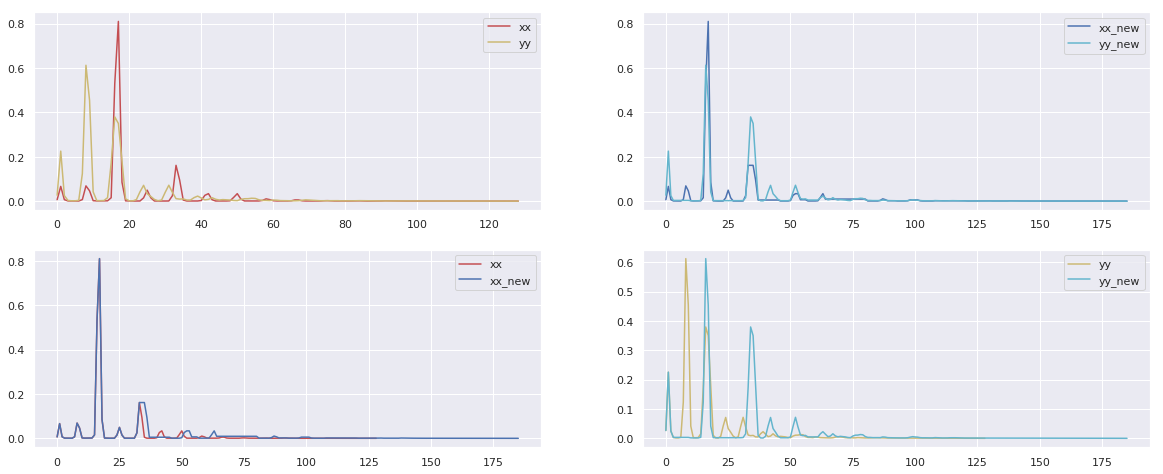

In [37]:
plt.figure(figsize=(20,8))
plt.subplot(2,2,1)
plt.plot(xx, c='r')
plt.plot(yy, c='y')
plt.legend(('xx','yy'))
#plt.ylim(0,0.15)

plt.subplot(2,2,2)
plt.plot(xx[xx_idx], c='b')
plt.plot(yy[yy_idx], c='c')
plt.legend(('xx_new','yy_new'))
#plt.ylim(0,0.15)

plt.subplot(2,2,3)
plt.plot(xx, c='r')
plt.plot(xx[xx_idx], c='b')
plt.legend(('xx','xx_new'))
#plt.ylim(0,0.15)

plt.subplot(2,2,4)
plt.plot(yy, c='y')
plt.plot(yy[yy_idx], c='c')
plt.legend(('yy','yy_new'))
#plt.ylim(0,0.15)

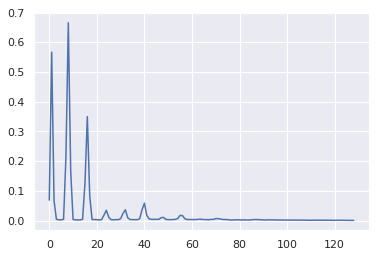

In [38]:
median_signal_idx = find_median_signal(D=X.astype(float))
median_signal = X[median_signal_idx,:]
plt.plot(median_signal)

In [39]:
#X.shape

D_dtw = np.zeros((600,600))

def warp_with_median_signal(xx, median_signal, distance=euclidean):
    _, path = fastdtw(xx, median_signal, dist=distance)
    
    idx = np.array([path[i][0] for i in range(len(path))])
    sig = xx[idx]
    
    return sig[:128]

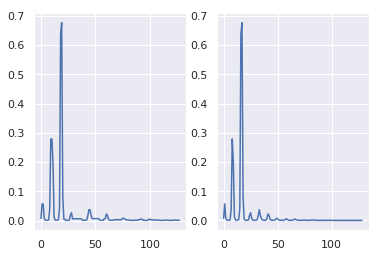

In [40]:
sig = X[10,:]
plt.subplot(1,2,1)
plt.plot(warp_with_median_signal(sig, median_signal, distance=euclidean))
#plt.xlim(0,2500)

plt.subplot(1,2,2)
plt.plot(sig)
#plt.xlim(0,2500)

In [41]:
from tqdm import tqdm

XX = []
for i in tqdm(range(X.shape[0])):
    XX.append(warp_with_median_signal(X[i,:], median_signal, distance=euclidean))

100%|██████████| 16608/16608 [12:27<00:00, 22.30it/s]


In [42]:
len(XX[2])

128

In [43]:
XX = np.vstack(XX)

In [44]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import xgboost
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle

X, y = shuffle(XX, y, random_state=3)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

classifier = xgboost.XGBClassifier(n_estimators=300, n_jobs=-1)
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)
ac = accuracy_score(y_test, y_pred)
print("Name: %s, ac: %f" % ('XGBoost', ac))

Name: XGBoost, ac: 0.739013


In [45]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[787, 185, 100],
       [321, 699, 109],
       [ 68,  84, 969]])